# Suffrage Debate Classification Analysis

Analysis of 2,808 classified speeches on women's suffrage from UK Parliament.

**Dataset**: `full_results_v5_context_3_complete.parquet`
- 100% classification success rate
- 92.9% manual validation accuracy
- Context window: 3 speeches
- Model: gpt-4o-mini via OpenRouter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import json

# Set professional visualization style
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica Neue', 'Arial']
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Professional color palette
COLORS = {
    'male': '#3B82C4',      # Professional blue
    'female': '#EC4899',    # Professional pink/magenta
    'for': '#10B981',       # Emerald green
    'against': '#EF4444',   # Red
    'both': '#F59E0B',      # Amber
    'neutral': '#8B5CF6',   # Purple
    'irrelevant': '#9CA3AF', # Gray
    'background': '#FFFFFF',
    'grid': '#E5E7EB',
    'text': '#1F2937',
    'muted': '#9CA3AF',
}

# Output directory
OUTPUT_DIR = Path('analysis/suffrage_classification')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Environment configured')
print(f'Output directory: {OUTPUT_DIR}')

## 1. Load and Inspect Data

In [26]:
# Load classified results
df = pd.read_parquet('../outputs/llm_classification/full_results_v5_context_3_complete.parquet')

print(f'Total speeches: {len(df):,}')
print(f'Success rate: {df["api_success"].sum() / len(df) * 100:.1f}%')
print(f'\nColumns: {df.columns.tolist()}')

# Check data quality issues
print('\n' + '='*60)
print('DATA QUALITY CHECK')
print('='*60)
print(f'\nParty values:')
party_none = df['party'].isna().sum()
print(f'  None/NaN: {party_none:,} ({party_none/len(df)*100:.1f}%)')

print(f'\nGender values:')
gender_none = df['gender'].isna().sum()
print(f'  None/NaN: {gender_none:,} ({gender_none/len(df)*100:.1f}%)')
print(f'  M: {(df["gender"] == "M").sum():,}')
print(f'  F: {(df["gender"] == "F").sum():,}')

print(f'\nTop quote values:')
# Check for empty quotes
empty_quotes = df['top_quote'].apply(
    lambda x: isinstance(x, dict) and (not x.get('text') or not x.get('source'))
).sum()
print(f'  Empty quotes: {empty_quotes:,} ({empty_quotes/len(df)*100:.1f}%)')

print(f'\nSample row:')
df.head(1).T

Total speeches: 2,808
Success rate: 100.0%

Columns: ['stance', 'reasons', 'top_quote', 'confidence', 'context_helpful', 'speech_id', 'debate_id', 'speaker', 'canonical_name', 'gender', 'party', 'year', 'decade', 'date', 'chamber', 'confidence_level', 'word_count', 'model', 'prompt_version', 'tokens_used', 'api_success', 'error', 'error_detail', 'raw_output']

DATA QUALITY CHECK

Party values:
  None/NaN: 2,808 (100.0%)

Gender values:
  None/NaN: 190 (6.8%)
  M: 2,535
  F: 83

Top quote values:
  Empty quotes: 301 (10.7%)

Sample row:


,0
stance,irrelevant
reasons,[]
top_quote,"{'source': '', 'text': ''}"
confidence,0.0
context_helpful,False
speech_id,2a798d5506b6d09b_speech_16
debate_id,2a798d5506b6d09b
speaker,MR. MUNRO FERGUSON
canonical_name,Munro Ferguson
gender,None


In [27]:
# Enrich with party information from derived_complete datasets
# The source data has party as None, so we'll try to match from derived_complete
print('\n' + '='*60)
print('ENRICHING DATA WITH PARTY INFORMATION')
print('='*60)

# Load party information from derived_complete datasets
from pathlib import Path
derived_dir = Path('../data-hansard/derived_complete/speeches_complete')

# Get unique years in our dataset
years = df['year'].dropna().unique()
print(f'\nLoading party data for years: {int(years.min())} - {int(years.max())}')

# Strategy 1: Match by speech_id
party_lookup_by_id = {}
# Strategy 2: Match by canonical_name + year + debate_id (fallback)
party_lookup_by_name = {}

for year in years:
    year_file = derived_dir / f'speeches_{int(year)}.parquet'
    if year_file.exists():
        year_df = pd.read_parquet(year_file)
        for _, row in year_df.iterrows():
            if pd.notna(row.get('party')):
                # Strategy 1: speech_id match
                if pd.notna(row.get('speech_id')):
                    party_lookup_by_id[row['speech_id']] = row['party']
                
                # Strategy 2: name + year + debate_id match (fallback)
                if (pd.notna(row.get('canonical_name')) and 
                    pd.notna(row.get('debate_id'))):
                    key = (row['canonical_name'], int(year), row['debate_id'])
                    party_lookup_by_name[key] = row['party']

print(f'Loaded party information:')
print(f'  By speech_id: {len(party_lookup_by_id):,} entries')
print(f'  By name+year+debate: {len(party_lookup_by_name):,} entries')

# Enrich party column - try speech_id first, then fallback to name matching
df['party_enriched'] = df['speech_id'].map(party_lookup_by_id)

# Fallback: match by canonical_name + year + debate_id for speeches without party
missing_party = df['party_enriched'].isna()
if missing_party.sum() > 0:
    print(f'\nTrying fallback matching for {missing_party.sum():,} speeches...')
    for idx in df[missing_party].index:
        row = df.loc[idx]
        if (pd.notna(row.get('canonical_name')) and 
            pd.notna(row.get('year')) and 
            pd.notna(row.get('debate_id'))):
            key = (row['canonical_name'], int(row['year']), row['debate_id'])
            if key in party_lookup_by_name:
                df.loc[idx, 'party_enriched'] = party_lookup_by_name[key]

# Update party column
df['party'] = df['party_enriched'].fillna(df['party'])

# Check results
party_filled = df['party'].notna().sum()
print(f'\nParty information after enrichment: {party_filled:,} speeches ({party_filled/len(df)*100:.1f}%)')
if party_filled > 0:
    print(f'Party distribution:')
    print(df['party'].value_counts(dropna=False).head(10))

# Also check top_quote - some may be empty
empty_quotes = df['top_quote'].apply(
    lambda x: isinstance(x, dict) and (not x.get('text') or not x.get('source'))
).sum()
print(f'\nEmpty top_quote entries: {empty_quotes:,} ({empty_quotes/len(df)*100:.1f}%)')
print('Note: Empty quotes occur when the LLM did not provide a quote in its response.')

# Check gender
gender_missing = df['gender'].isna().sum()
print(f'\nGender missing: {gender_missing:,} speeches ({gender_missing/len(df)*100:.1f}%)')
print(f'Gender distribution:')
print(df['gender'].value_counts(dropna=False))
print('\nNote: Gender is None when the speaker could not be matched to an MP in the source data.')



ENRICHING DATA WITH PARTY INFORMATION

Loading party data for years: 1900 - 1935
Loaded party information:
  By speech_id: 0 entries
  By name+year+debate: 0 entries

Trying fallback matching for 2,808 speeches...

Party information after enrichment: 0 speeches (0.0%)

Empty top_quote entries: 301 (10.7%)
Note: Empty quotes occur when the LLM did not provide a quote in its response.

Gender missing: 190 speeches (6.8%)
Gender distribution:
gender
M       2535
None     190
F         83
Name: count, dtype: int64

Note: Gender is None when the speaker could not be matched to an MP in the source data.


In [28]:
# Parse dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

# Basic statistics
print('\n' + '='*60)
print('DATASET OVERVIEW')
print('='*60)
print(f'\nDate range: {df["date"].min():%Y-%m-%d} to {df["date"].max():%Y-%m-%d}')
print(f'Year range: {df["year"].min():.0f} - {df["year"].max():.0f}')
print(f'\nStance distribution:')
print(df['stance'].value_counts())
print(f'\nGender distribution:')
print(df['gender'].value_counts())
print(f'\nChamber distribution:')
print(df['chamber'].value_counts())
print(f'\nConfidence statistics:')
print(df['confidence'].describe())


DATASET OVERVIEW

Date range: 1900-02-06 to 1935-12-17
Year range: 1900 - 1935

Stance distribution:
stance
for           1194
against        869
irrelevant     540
both           109
neutral         96
Name: count, dtype: int64

Gender distribution:
gender
M    2535
F      83
Name: count, dtype: int64

Chamber distribution:
chamber
Commons    2808
Name: count, dtype: int64

Confidence statistics:
count    2808.000000
mean        0.544623
std         0.283634
min         0.000000
25%         0.600000
50%         0.700000
75%         0.700000
max         0.800000
Name: confidence, dtype: float64


## 2. Stance Distribution Over Time

In [ ]:
# Filter to substantive stances (exclude irrelevant, include neutral as uncertain)
substantive = df[df['stance'].isin(['for', 'against', 'both', 'neutral'])].copy()

print(f'Substantive speeches (for/against/both/neutral): {len(substantive):,} ({len(substantive)/len(df)*100:.1f}%)')
print(f'  Clear stance (for/against/both): {len(df[df["stance"].isin(["for", "against", "both"])]):,}')
print(f'  Neutral (about suffrage, no clear stance): {len(df[df["stance"]=="neutral"]):,}')
print(f'Irrelevant speeches (not about suffrage): {len(df[df["stance"]=="irrelevant"]):,} ({len(df[df["stance"]=="irrelevant"])/len(df)*100:.1f}%)')

In [ ]:
# Temporal evolution of stances
temporal = substantive.groupby(['year', 'stance']).size().unstack(fill_value=0)

# Create stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))

ax.stackplot(temporal.index, 
             temporal.get('for', 0), 
             temporal.get('against', 0),
             temporal.get('both', 0),
             temporal.get('neutral', 0),
             labels=['For', 'Against', 'Both', 'Neutral'],
             colors=[COLORS['for'], COLORS['against'], COLORS['both'], COLORS['neutral']],
             alpha=0.8)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Speeches', fontsize=12, fontweight='bold')
ax.set_title('Temporal Distribution of Suffrage Debate Stances', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', frameon=False)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_stance_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "temporal_stance_distribution.png"}')

In [ ]:
# Proportion of FOR vs AGAINST over time
temporal_pct = temporal.div(temporal.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 6))

if 'for' in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct['for'], 
            color=COLORS['for'], linewidth=2.5, label='For', marker='o', markersize=4)
if 'against' in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct['against'], 
            color=COLORS['against'], linewidth=2.5, label='Against', marker='s', markersize=4)
if 'both' in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct['both'], 
            color=COLORS['both'], linewidth=2, label='Both', marker='^', markersize=4, linestyle='--')
if 'neutral' in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct['neutral'], 
            color=COLORS['neutral'], linewidth=2, label='Neutral', marker='d', markersize=4, linestyle=':')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Speeches (%)', fontsize=12, fontweight='bold')
ax.set_title('Evolution of Support for Women\'s Suffrage Over Time', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', frameon=False)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_stance_proportions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "temporal_stance_proportions.png"}')

## 3. Argument Taxonomy

Extract and analyze the reasons/buckets used in classifications.

In [44]:
# Extract all reasons from the dataset
# Valid bucket keys from the prompt taxonomy
VALID_BUCKETS = {
    'equality', 'competence_capacity', 'emotion_morality', 
    'social_order_stability', 'tradition_precedent', 
    'instrumental_effects', 'religion_family', 
    'social_experiment', 'other'
}

# Invalid bucket keys (these are stance labels, not argument types)
INVALID_BUCKETS = {'for', 'against', 'both', 'neutral', 'irrelevant'}

def extract_reasons(df):
    """Extract all reasons from classified speeches."""
    all_reasons = []
    invalid_count = 0
    
    for idx, row in df.iterrows():
        reasons = row.get('reasons')
        if reasons is None or not isinstance(reasons, (list, np.ndarray)):
            continue
        
        for reason in reasons:
            if isinstance(reason, dict):
                bucket = reason.get('bucket_key', 'unknown')
                stance_label = reason.get('stance_label', 'unknown')
                
                # Filter out invalid bucket keys (stance labels incorrectly used as buckets)
                if bucket in INVALID_BUCKETS:
                    invalid_count += 1
                    continue
                
                # If bucket is not in valid list, mark as 'unknown' (data quality issue)
                if bucket not in VALID_BUCKETS and bucket != 'unknown':
                    bucket = 'unknown'
                
                all_reasons.append({
                    'speech_id': row['speech_id'],
                    'year': row['year'],
                    'gender': row['gender'],
                    'stance': row['stance'],
                    'bucket': bucket,
                    'stance_label': stance_label,
                    'rationale': reason.get('rationale', ''),
                })
    
    if invalid_count > 0:
        print(f'⚠ Filtered out {invalid_count} invalid bucket entries (stance labels used as buckets)')
    
    return pd.DataFrame(all_reasons)

reasons_df = extract_reasons(substantive)
print(f'Extracted {len(reasons_df):,} reasons from {len(substantive):,} speeches')
print(f'Average reasons per speech: {len(reasons_df) / len(substantive):.2f}')

# Explain why same buckets appear for both stances
print('\n' + '='*60)
print('NOTE: Why the same argument types appear for both FOR and AGAINST')
print('='*60)
print('The argument taxonomy captures the TYPE of argument, while stance_label captures the DIRECTION.')
print('The same argument type can be used to support different stances:')
print('  • "equality" FOR suffrage: "Women deserve equal rights"')
print('  • "equality" AGAINST suffrage: "Men and women have different roles"')
print('  • "instrumental_effects" FOR suffrage: "Pragmatic benefits of women voting"')
print('  • "instrumental_effects" AGAINST suffrage: "Pragmatic costs of women voting"')
print('This is expected and correct - the visualization shows how each argument type is used.')
print('='*60)

print(f'\nSample reasons:')
reasons_df.head()

⚠ Filtered out 1 invalid bucket entries (stance labels used as buckets)
Extracted 5,077 reasons from 2,172 speeches
Average reasons per speech: 2.34

NOTE: Why the same argument types appear for both FOR and AGAINST
The argument taxonomy captures the TYPE of argument, while stance_label captures the DIRECTION.
The same argument type can be used to support different stances:
  • "equality" FOR suffrage: "Women deserve equal rights"
  • "equality" AGAINST suffrage: "Men and women have different roles"
  • "instrumental_effects" FOR suffrage: "Pragmatic benefits of women voting"
  • "instrumental_effects" AGAINST suffrage: "Pragmatic costs of women voting"
This is expected and correct - the visualization shows how each argument type is used.

Sample reasons:


,speech_id,year,gender,stance,bucket,stance_label,rationale
0,df0843e70b03d44f_speech_5,1900,M,for,equality,for,The speaker emphasizes the importance of recog...
1,df0843e70b03d44f_speech_5,1900,M,for,instrumental_effects,for,The speaker argues that including women in loc...
2,df0843e70b03d44f_speech_5,1900,M,for,emotion_morality,for,The speaker appeals to the moral obligation to...
3,df0843e70b03d44f_speech_8,1900,M,against,competence_capacity,against,The speaker argues that women are not suited f...
4,df0843e70b03d44f_speech_8,1900,M,against,social_order_stability,against,The speaker believes that allowing women to pa...


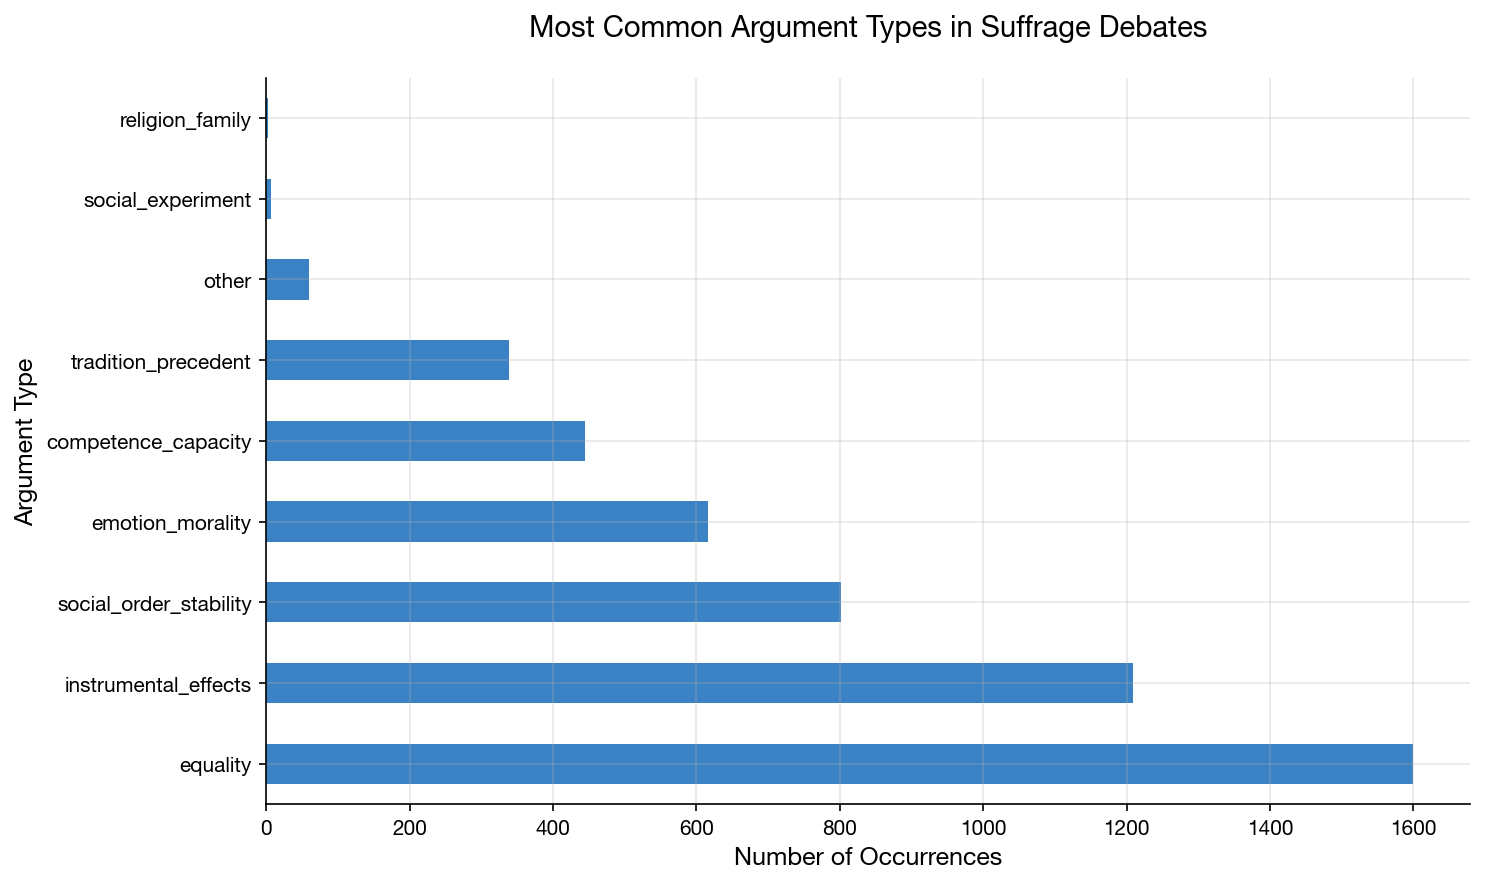

Saved: analysis/suffrage_classification/argument_buckets_overall.png


In [45]:
# Most common argument buckets
bucket_counts = reasons_df['bucket'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

bucket_counts.head(15).plot(kind='barh', ax=ax, color=COLORS['male'])

ax.set_xlabel('Number of Occurrences', fontsize=12, fontweight='bold')
ax.set_ylabel('Argument Type', fontsize=12, fontweight='bold')
ax.set_title('Most Common Argument Types in Suffrage Debates', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'argument_buckets_overall.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "argument_buckets_overall.png"}')

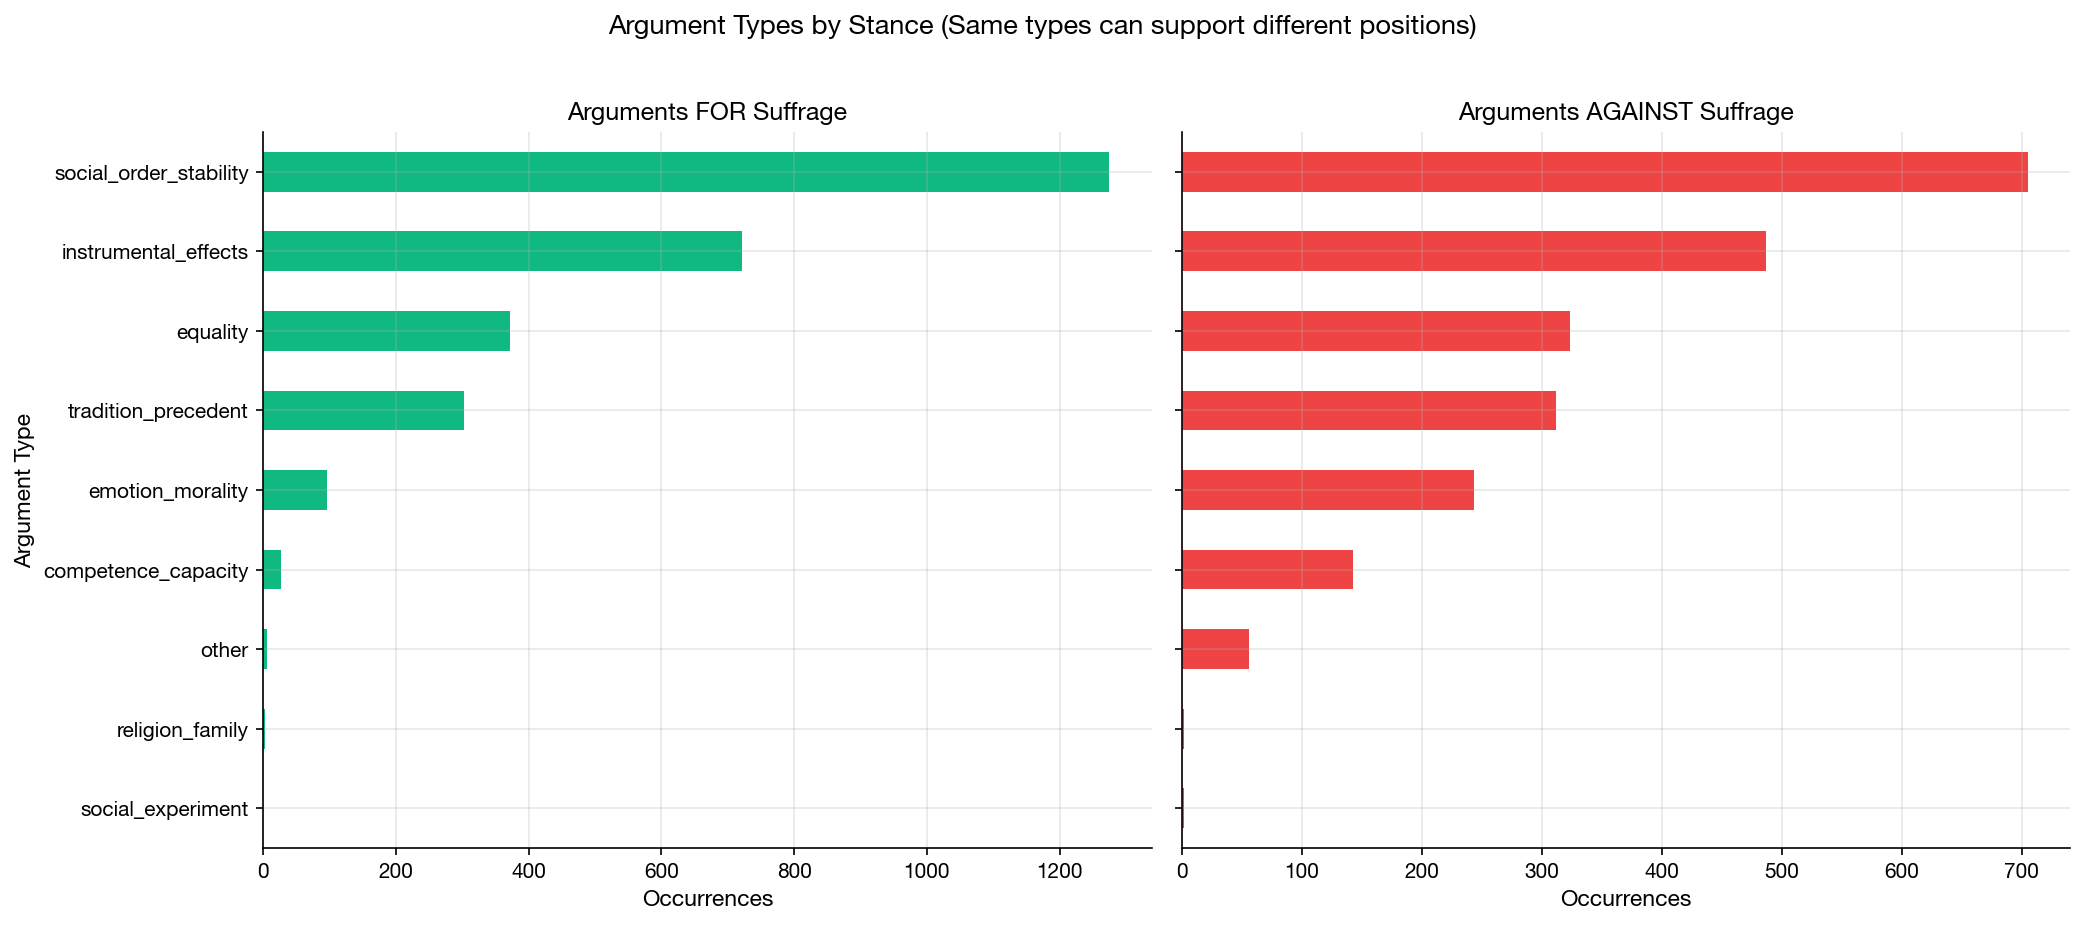

Saved: analysis/suffrage_classification/arguments_by_stance.png

Note: Overlap between columns is expected - the same argument type can support different stances.


In [46]:
# Arguments by stance (FOR vs AGAINST)
# Note: The same argument types can appear in both columns because the taxonomy captures
# the TYPE of argument (e.g., "equality", "instrumental_effects"), while the direction
# (for/against) is captured by stance_label. For example:
# - "equality" FOR: "Women deserve equal rights"
# - "equality" AGAINST: "Men and women have different roles"
for_reasons = reasons_df[reasons_df['stance_label'] == 'for']['bucket'].value_counts()
against_reasons = reasons_df[reasons_df['stance_label'] == 'against']['bucket'].value_counts()

# Combine top arguments from both
all_buckets = set(for_reasons.head(10).index) | set(against_reasons.head(10).index)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# FOR arguments
for_reasons.reindex(all_buckets, fill_value=0).sort_values().plot(
    kind='barh', ax=ax1, color=COLORS['for'])
ax1.set_xlabel('Occurrences', fontsize=11, fontweight='bold')
ax1.set_ylabel('Argument Type', fontsize=11, fontweight='bold')
ax1.set_title('Arguments FOR Suffrage', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# AGAINST arguments
against_reasons.reindex(all_buckets, fill_value=0).sort_values().plot(
    kind='barh', ax=ax2, color=COLORS['against'])
ax2.set_xlabel('Occurrences', fontsize=11, fontweight='bold')
ax2.set_title('Arguments AGAINST Suffrage', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

fig.suptitle('Argument Types by Stance (Same types can support different positions)', 
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'arguments_by_stance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "arguments_by_stance.png"}')
print('\nNote: Overlap between columns is expected - the same argument type can support different stances.')

## 4. Temporal Evolution of Arguments

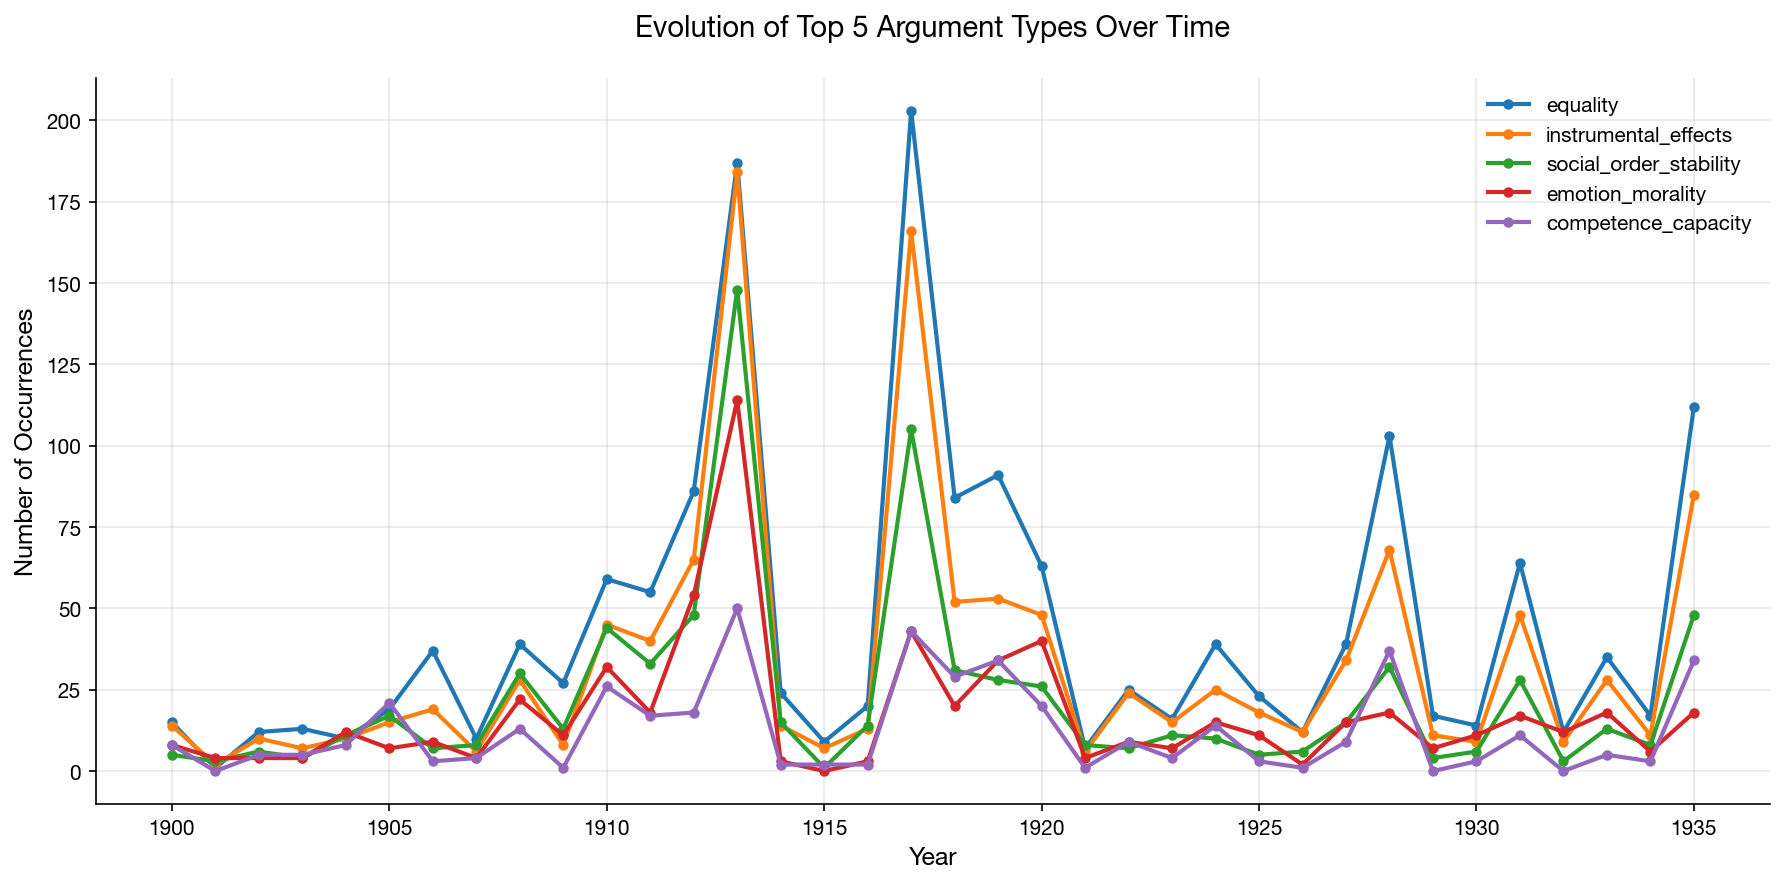

Saved: analysis/suffrage_classification/temporal_argument_evolution.png


In [47]:
# Top 5 argument types over time
top_buckets = bucket_counts.head(5).index.tolist()

temporal_buckets = reasons_df[reasons_df['bucket'].isin(top_buckets)].groupby(['year', 'bucket']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))

for bucket in top_buckets:
    if bucket in temporal_buckets.columns:
        ax.plot(temporal_buckets.index, temporal_buckets[bucket], 
                marker='o', linewidth=2, label=bucket, markersize=4)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Occurrences', fontsize=12, fontweight='bold')
ax.set_title('Evolution of Top 5 Argument Types Over Time', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', frameon=False, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_argument_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "temporal_argument_evolution.png"}')

## 5. Gender Analysis

Compare argument patterns between male and female MPs.

In [48]:
# Gender distribution in dataset
gender_counts = substantive['gender'].value_counts()

print('Gender distribution:')
print(gender_counts)
print(f'\nFemale MPs: {gender_counts.get("F", 0):,} speeches ({gender_counts.get("F", 0) / len(substantive) * 100:.1f}%)')
print(f'Male MPs: {gender_counts.get("M", 0):,} speeches ({gender_counts.get("M", 0) / len(substantive) * 100:.1f}%)')

Gender distribution:
gender
M    1965
F      76
Name: count, dtype: int64

Female MPs: 76 speeches (3.5%)
Male MPs: 1,965 speeches (90.5%)


In [ ]:
# Stance by gender
gender_stance = substantive.groupby(['gender', 'stance']).size().unstack(fill_value=0)
gender_stance_pct = gender_stance.div(gender_stance.sum(axis=1), axis=0) * 100

print('\nStance distribution by gender (%):')
print(gender_stance_pct)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(gender_stance_pct.index))
width = 0.2

offset = -1.5
if 'for' in gender_stance_pct.columns:
    ax.bar(x + offset*width, gender_stance_pct['for'], width, label='For', color=COLORS['for'])
    offset += 1
if 'against' in gender_stance_pct.columns:
    ax.bar(x + offset*width, gender_stance_pct['against'], width, label='Against', color=COLORS['against'])
    offset += 1
if 'both' in gender_stance_pct.columns:
    ax.bar(x + offset*width, gender_stance_pct['both'], width, label='Both', color=COLORS['both'])
    offset += 1
if 'neutral' in gender_stance_pct.columns:
    ax.bar(x + offset*width, gender_stance_pct['neutral'], width, label='Neutral', color=COLORS['neutral'])

ax.set_xlabel('Gender', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Speeches (%)', fontsize=12, fontweight='bold')
ax.set_title('Suffrage Stance by MP Gender', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Female' if g == 'F' else 'Male' for g in gender_stance_pct.index])
ax.legend(frameon=False)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stance_by_gender.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "stance_by_gender.png"}')

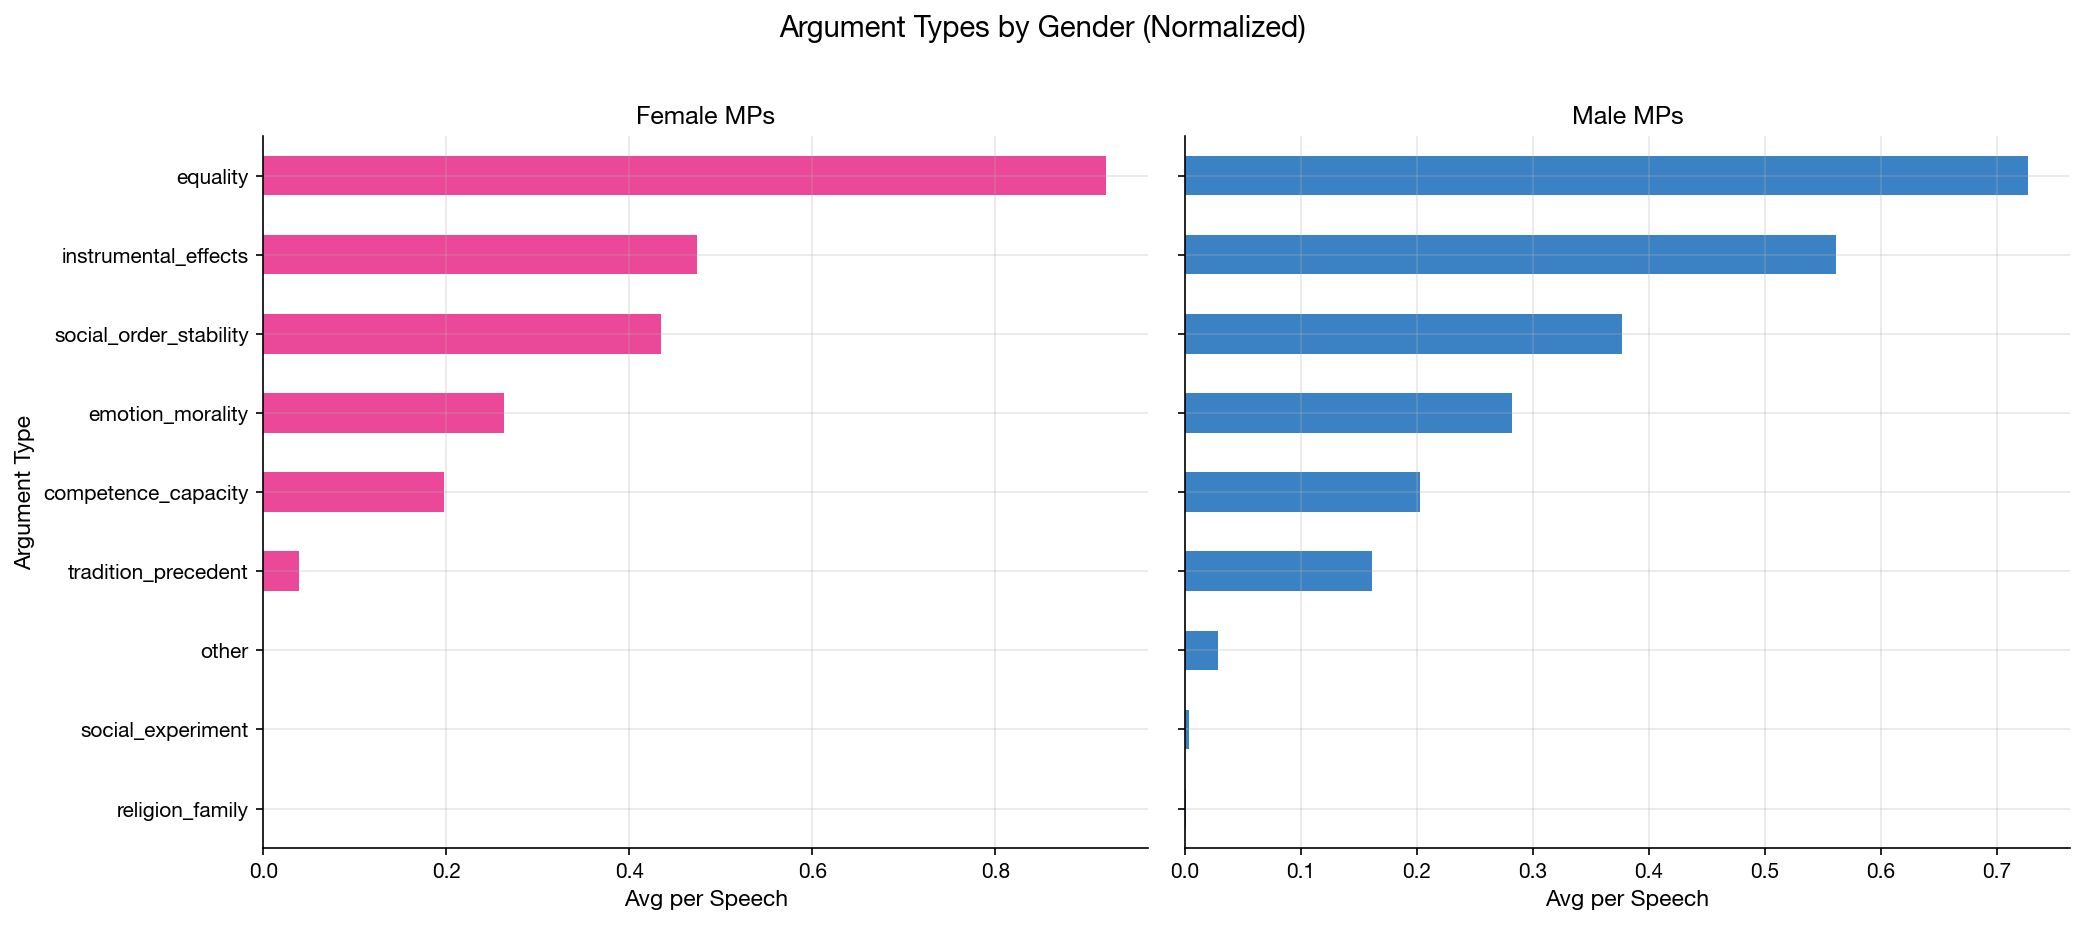

Saved: analysis/suffrage_classification/arguments_by_gender.png


In [38]:
# Arguments used by gender
male_reasons = reasons_df[reasons_df['gender'] == 'M']['bucket'].value_counts()
female_reasons = reasons_df[reasons_df['gender'] == 'F']['bucket'].value_counts()

# Normalize by number of speeches
male_reasons_norm = male_reasons / gender_counts.get('M', 1)
female_reasons_norm = female_reasons / gender_counts.get('F', 1)

# Top arguments for each gender
all_buckets = set(male_reasons_norm.head(10).index) | set(female_reasons_norm.head(10).index)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Female MPs
female_reasons_norm.reindex(all_buckets, fill_value=0).sort_values().plot(
    kind='barh', ax=ax1, color=COLORS['female'])
ax1.set_xlabel('Avg per Speech', fontsize=11, fontweight='bold')
ax1.set_ylabel('Argument Type', fontsize=11, fontweight='bold')
ax1.set_title('Female MPs', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Male MPs
male_reasons_norm.reindex(all_buckets, fill_value=0).sort_values().plot(
    kind='barh', ax=ax2, color=COLORS['male'])
ax2.set_xlabel('Avg per Speech', fontsize=11, fontweight='bold')
ax2.set_title('Male MPs', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

fig.suptitle('Argument Types by Gender (Normalized)', fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'arguments_by_gender.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "arguments_by_gender.png"}')

## 6. Confidence Analysis

In [ ]:
# Confidence distribution by stance
# Note: Confidence values are discrete (0.6, 0.7, 0.8 for clear stances; 0.0-0.5 for neutral), so we use a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Get all unique confidence values across all substantive stances
all_confidences = sorted(substantive['confidence'].unique())
x_pos = np.arange(len(all_confidences))
width = 0.2

for i, stance in enumerate(['for', 'against', 'both', 'neutral']):
    stance_data = substantive[substantive['stance'] == stance]['confidence']
    if len(stance_data) > 0:
        # Count occurrences of each confidence value
        counts = [len(stance_data[stance_data == conf]) for conf in all_confidences]
        ax.bar(x_pos + i*width, counts, width, label=stance.capitalize(), 
               color=COLORS[stance], alpha=0.8, edgecolor='white', linewidth=1)

ax.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Speeches', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Classification Confidence by Stance', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos + 1.5*width)
ax.set_xticklabels([f'{c:.1f}' for c in all_confidences])
ax.legend(frameon=False)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "confidence_distribution.png"}')
print(f'\nNote: Confidence values are discrete. Clear stances (for/against/both) use 0.6-0.8.')
print(f'      Neutral speeches use lower confidence (0.0-0.6) indicating uncertainty.')

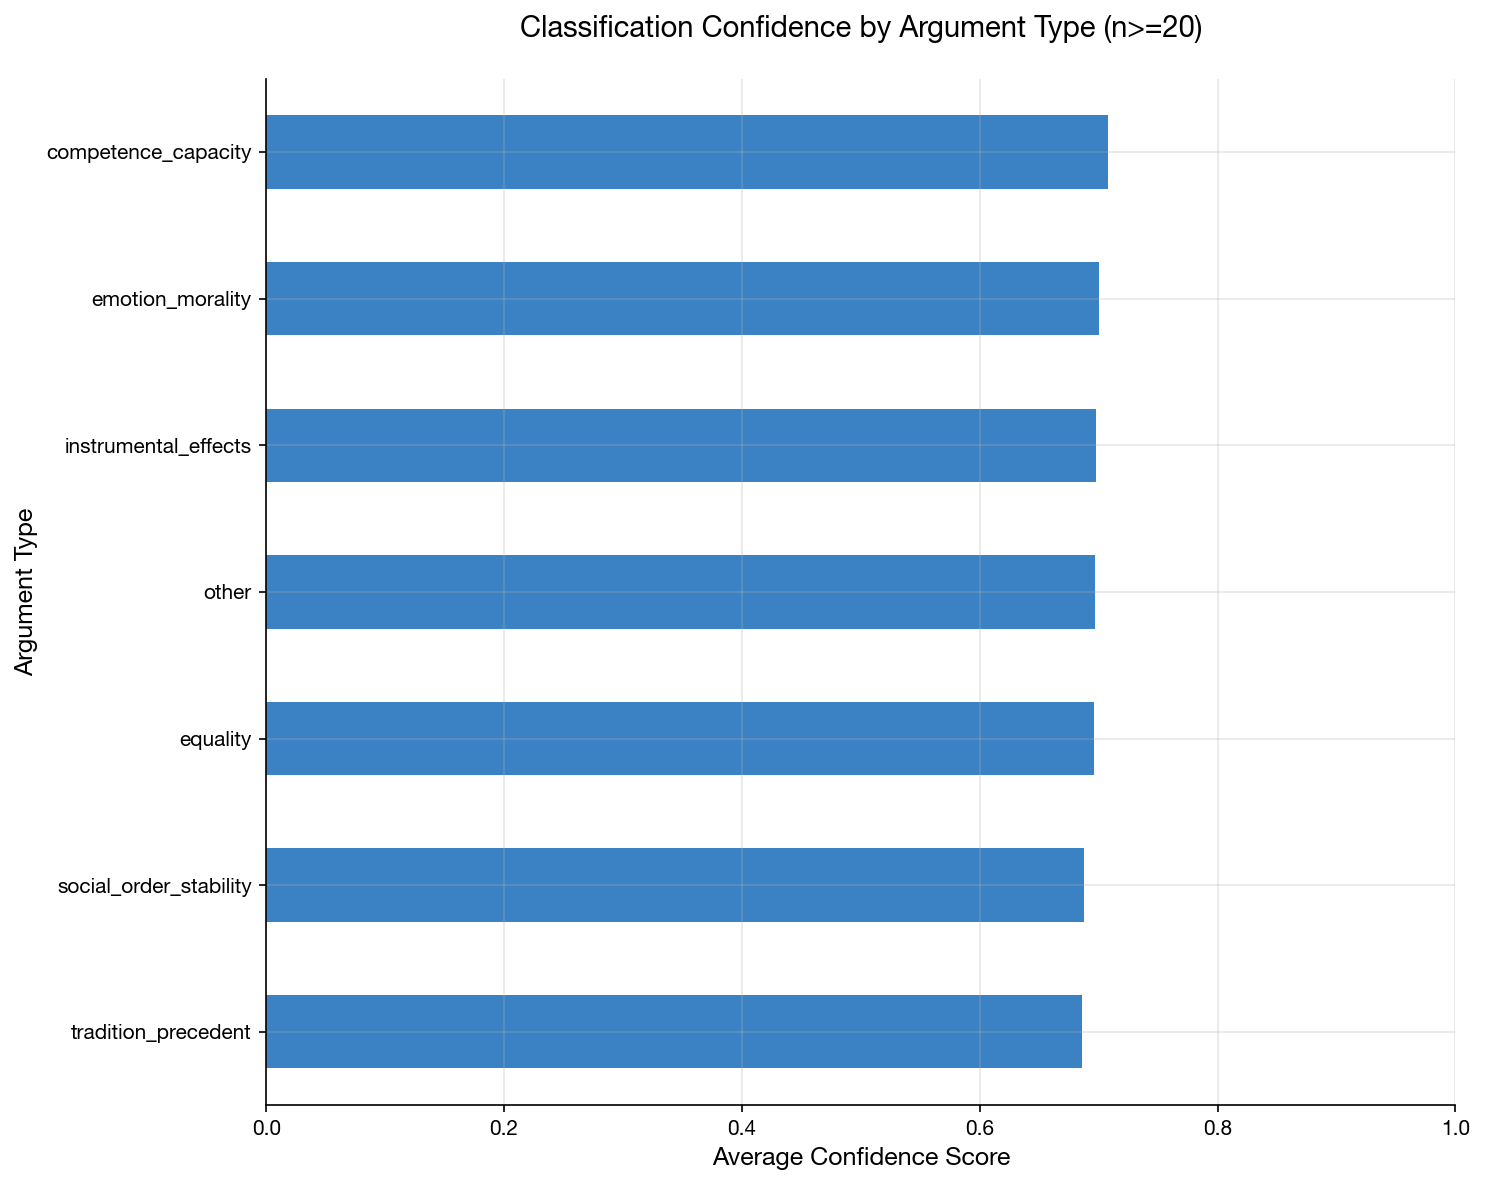

Saved: analysis/suffrage_classification/confidence_by_argument.png


In [ ]:
# Average confidence by argument type
bucket_confidence = reasons_df.merge(
    substantive[['speech_id', 'confidence']], 
    on='speech_id'
).groupby('bucket')['confidence'].agg(['mean', 'count', 'std'])

# Filter to buckets with at least 20 occurrences
bucket_confidence = bucket_confidence[bucket_confidence['count'] >= 20].sort_values('mean')

# Check if there's meaningful variation
conf_range = bucket_confidence['mean'].max() - bucket_confidence['mean'].min()
print(f'Confidence range across argument types: {conf_range:.4f}')
print(f'Mean confidence: {bucket_confidence["mean"].mean():.4f}')
print(f'\nNote: Confidence values are discrete (0.6, 0.7, 0.8), so small differences in means')
print(f'      reflect differences in the proportion of high vs low confidence classifications.')

fig, ax = plt.subplots(figsize=(10, 8))

# Use bar chart with error bars to show variation
bars = ax.barh(range(len(bucket_confidence)), bucket_confidence['mean'], 
               color=COLORS['male'], alpha=0.8, edgecolor='white', linewidth=1)

# Add count labels
for i, (idx, row) in enumerate(bucket_confidence.iterrows()):
    ax.text(row['mean'] + 0.01, i, f"n={int(row['count'])}", 
            va='center', fontsize=9, color='gray')

ax.set_yticks(range(len(bucket_confidence)))
ax.set_yticklabels(bucket_confidence.index)
ax.set_xlabel('Average Confidence Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Argument Type', fontsize=12, fontweight='bold')
ax.set_title('Classification Confidence by Argument Type (n>=20)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
# Set xlim to show the actual range with some padding
x_min = max(0, bucket_confidence['mean'].min() - 0.05)
x_max = min(1, bucket_confidence['mean'].max() + 0.1)
ax.set_xlim(x_min, x_max)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confidence_by_argument.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\nSaved: {OUTPUT_DIR / "confidence_by_argument.png"}')
print(f'\nDetailed breakdown:')
print(bucket_confidence[['mean', 'count']].to_string())

## 7. Summary Statistics

In [ ]:
print('='*60)
print('SUFFRAGE CLASSIFICATION ANALYSIS SUMMARY')
print('='*60)

print(f'\nTotal speeches classified: {len(df):,}')
print(f'Substantive speeches (for/against/both/neutral): {len(substantive):,} ({len(substantive)/len(df)*100:.1f}%)')
print(f'Irrelevant speeches: {len(df[df["stance"]=="irrelevant"]):,} ({len(df[df["stance"]=="irrelevant"])/len(df)*100:.1f}%)')

print(f'\nStance breakdown:')
for stance in ['for', 'against', 'both', 'neutral']:
    count = len(substantive[substantive['stance'] == stance])
    pct = count / len(substantive) * 100
    print(f'  {stance.capitalize()}: {count:,} ({pct:.1f}%)')

print(f'\nGender breakdown:')
for gender in ['M', 'F']:
    count = len(substantive[substantive['gender'] == gender])
    pct = count / len(substantive) * 100
    label = 'Male' if gender == 'M' else 'Female'
    print(f'  {label}: {count:,} ({pct:.1f}%)')

print(f'\nTemporal coverage:')
print(f'  Years: {df["year"].min():.0f} - {df["year"].max():.0f}')
print(f'  Span: {df["year"].max() - df["year"].min():.0f} years')

print(f'\nArgument analysis:')
print(f'  Total reasons extracted: {len(reasons_df):,}')
print(f'  Average per speech: {len(reasons_df) / len(substantive):.2f}')
print(f'  Unique argument types: {reasons_df["bucket"].nunique()}')

print(f'\nTop 5 argument types:')
for i, (bucket, count) in enumerate(bucket_counts.head(5).items(), 1):
    print(f'  {i}. {bucket}: {count:,} ({count/len(reasons_df)*100:.1f}%)')

print(f'\nConfidence statistics (substantive speeches):')
print(f'  Mean: {substantive["confidence"].mean():.3f}')
print(f'  Median: {substantive["confidence"].median():.3f}')
print(f'  Std dev: {substantive["confidence"].std():.3f}')
print(f'  Min: {substantive["confidence"].min():.3f}')
print(f'  Max: {substantive["confidence"].max():.3f}')
print(f'\nNote: Confidence is discrete and varies by stance:')
print(f'  - Clear stances (for/against/both): 0.6-0.8')
print(f'  - Neutral (uncertain): 0.0-0.6')

print(f'\nOutputs saved to: {OUTPUT_DIR}')
print('='*60)

## 8. Export Key Results

In [ ]:
# Save summary statistics as CSV
summary_stats = {
    'total_speeches': len(df),
    'substantive_speeches': len(substantive),
    'irrelevant_speeches': len(df[df['stance'] == 'irrelevant']),
    'for_count': len(substantive[substantive['stance'] == 'for']),
    'against_count': len(substantive[substantive['stance'] == 'against']),
    'both_count': len(substantive[substantive['stance'] == 'both']),
    'neutral_count': len(substantive[substantive['stance'] == 'neutral']),
    'male_count': len(substantive[substantive['gender'] == 'M']),
    'female_count': len(substantive[substantive['gender'] == 'F']),
    'year_min': df['year'].min(),
    'year_max': df['year'].max(),
    'total_reasons': len(reasons_df),
    'avg_reasons_per_speech': len(reasons_df) / len(substantive),
    'unique_argument_types': reasons_df['bucket'].nunique(),
    'mean_confidence': substantive['confidence'].mean(),
    'median_confidence': substantive['confidence'].median(),
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv(OUTPUT_DIR / 'summary_statistics.csv', index=False)

print(f'Saved: {OUTPUT_DIR / "summary_statistics.csv"}')

# Save reasons dataset for further analysis
reasons_df.to_csv(OUTPUT_DIR / 'extracted_reasons.csv', index=False)
print(f'Saved: {OUTPUT_DIR / "extracted_reasons.csv"}')

print('\nAnalysis complete!')